# Train/Test/Validation Dataset Splitting

Three popular pre-trained CNN models for classifying audio events have been selected, and the embeddings for each model will be extracted for every audio signal.
- VGGish: https://github.com/tensorflow/models/tree/master/research/audioset/vggish
- YAMNet: https://github.com/tensorflow/models/tree/master/research/audioset/yamnet
- PANNs: https://github.com/qiuqiangkong/audioset_tagging_cnn

### Code Functionality Breakdown

#### **1. Purpose of the Code**
This code provides a structured pipeline for **splitting the EMODB dataset** into training, validation, and test sets while addressing:
- **Class imbalance**: Assigning weights for balanced training.
- **Cross-validation**: Creating stratified folds to ensure emotion labels are evenly distributed across splits.
- **Reproducibility**: Using fixed random states.

---

#### **2. Key Functional Components**

##### **`DatasetSplitter` Class**
- **Purpose:** Handles the entire dataset splitting workflow, from data validation to saving the final split dataset.

###### **Attributes (in `__init__`)**
- **`csv_path`**: Path to the metadata CSV containing file paths and emotion labels.
- **`wav_base_path`**: Directory containing the original `.wav` audio files.
- **`pkl_base_path`**: Directory for the preprocessed `.pkl` files.
- **`output_path`**: Destination for the split dataset CSV.
- **`n_splits`**: Number of cross-validation folds (default: 5).
- **`random_state`**: Ensures reproducibility.

---

##### **3. Main Methods**

###### **`load_and_validate_data`**
- **Purpose:** Loads the metadata and validates it.
- **Key Steps:**
  1. **Load CSV:** Reads the dataset metadata into a DataFrame.
  2. **Validate Paths:** Ensures directories for `.wav` and `.pkl` files exist.
  3. **Validate Columns:** Checks that required columns (`path` and `emotion_label`) are present.
  4. **Check Labels:** Ensures no missing values in emotion labels.

---

###### **`analyze_class_distribution`**
- **Purpose:** Analyzes and visualizes the distribution of emotion labels in the dataset.
- **Key Steps:**
  - Counts the occurrences of each label.
  - Optionally plots a bar chart of label distributions.

---

###### **`calculate_class_weights`**
- **Purpose:** Computes class weights to handle class imbalance.
- **Key Steps:**
  - For each label, calculates weight as \( \text{weight} = \frac{\text{total samples}}{\text{n\_classes} \times \text{label count}} \).
  - Adds a `weight` column to the DataFrame for use during model training.

---

###### **`generate_pkl_paths`**
- **Purpose:** Converts `.wav` file paths to `.pkl` paths.
- **Key Steps:**
  - Extracts the stem of each `.wav` file and constructs the corresponding `.pkl` file path in the `pkl_base_path` directory.

---

###### **`create_stratified_folds`**
- **Purpose:** Splits the dataset into stratified cross-validation folds.
- **Key Steps:**
  - Uses `StratifiedKFold` to split the data into folds.
  - Ensures the class distribution within each fold matches the overall dataset distribution.
  - Adds a `fold` column to the DataFrame, indicating the fold assignment.

---

###### **`save_split_dataset`**
- **Purpose:** Saves the processed dataset with class weights, fold assignments, and `.pkl` paths.
- **Key Steps:**
  - Shuffles the dataset for randomness.
  - Saves the DataFrame as a CSV file in the specified `output_path`.

---

###### **`process_dataset`**
- **Purpose:** Main method orchestrating the entire dataset processing workflow.
- **Key Steps:**
  1. Validates the dataset.
  2. Analyzes class distribution.
  3. Calculates class weights.
  4. Generates `.pkl` file paths.
  5. Creates stratified folds.
  6. Saves the final dataset.

---

##### **4. Main Function**
- **Purpose:** Configures paths, initializes the `DatasetSplitter`, and executes the processing pipeline.

---

#### **3. Usage in Your Project**
This code contributes the **dataset preparation stage** in your **speech emotion recognition project**:
- **Stratified Splits:** Ensures even emotion label distribution across training, validation, and test sets.
- **Class Balancing:** Handles imbalanced datasets by calculating and providing class weights.
- **Cross-Validation:** Supports robust model evaluation using multiple folds.
- **Organized Data:** Converts raw file paths into structured `.pkl` paths for downstream processing.

Let me know if you need further clarification or modifications!

2024-12-07 15:39:42,224 - INFO - 
Class distribution:
2024-12-07 15:39:42,224 - INFO - emotion_label
anger        127
boredom       81
neutral       79
happiness     71
fear          69
sadness       62
disgust       46
Name: count, dtype: int64


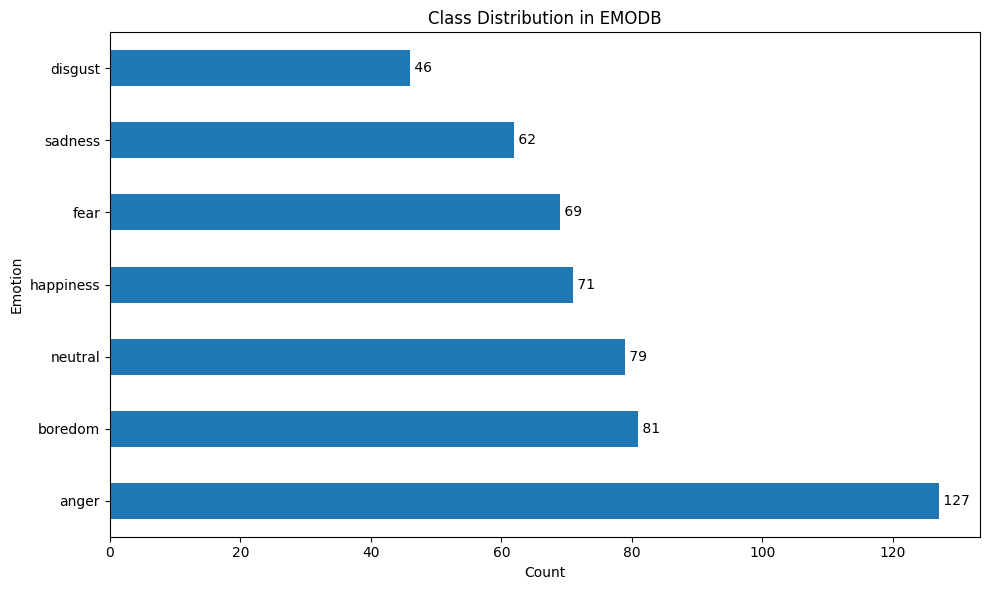

2024-12-07 15:39:42,350 - INFO - 
Samples per fold:
2024-12-07 15:39:42,353 - INFO - fold
0    107
1    107
2    107
3    107
4    107
Name: count, dtype: int64
2024-12-07 15:39:42,359 - INFO - 
Fold 0 class distribution:
2024-12-07 15:39:42,360 - INFO - emotion_label
anger        25
boredom      17
neutral      16
fear         14
happiness    14
sadness      12
disgust       9
Name: count, dtype: int64
2024-12-07 15:39:42,367 - INFO - 
Fold 1 class distribution:
2024-12-07 15:39:42,368 - INFO - emotion_label
anger        26
boredom      16
neutral      16
happiness    14
fear         14
sadness      12
disgust       9
Name: count, dtype: int64
2024-12-07 15:39:42,370 - INFO - 
Fold 2 class distribution:
2024-12-07 15:39:42,385 - INFO - emotion_label
anger        26
boredom      16
neutral      15
happiness    15
fear         13
sadness      12
disgust      10
Name: count, dtype: int64
2024-12-07 15:39:42,402 - INFO - 
Fold 3 class distribution:
2024-12-07 15:39:42,410 - INFO - emotion

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import logging
from typing import Tuple, Optional
from pathlib import Path

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('dataset_splitting.log'),
        logging.StreamHandler()
    ]
)

class DatasetSplitter:
    """Class to handle dataset splitting operations for emotion recognition"""
    
    def __init__(self, 
                 csv_path: str,
                 wav_base_path: str,
                 pkl_base_path: str,
                 output_path: str,
                 n_splits: int = 5,
                 random_state: int = 23):
        """
        Initialize DatasetSplitter
        
        Args:
            csv_path: Path to the metadata CSV file
            wav_base_path: Base path for WAV files
            pkl_base_path: Base path for PKL files
            output_path: Path to save the split dataset
            n_splits: Number of folds for cross-validation
            random_state: Random seed for reproducibility
        """
        self.csv_path = Path(csv_path)
        self.wav_base_path = Path(wav_base_path)
        self.pkl_base_path = Path(pkl_base_path)
        self.output_path = Path(output_path)
        self.n_splits = n_splits
        self.random_state = random_state
        self.df = None
        
    def load_and_validate_data(self) -> bool:
        """
        Load and validate the dataset
        
        Returns:
            bool: True if validation successful, False otherwise
        """
        try:
            # Load data
            self.df = pd.read_csv(self.csv_path)
            
            # Validate paths
            if not all(path.exists() for path in [self.wav_base_path, self.pkl_base_path]):
                logging.error("Base paths do not exist")
                return False
                
            # Validate required columns
            required_columns = ['path', 'emotion_label']
            if not all(col in self.df.columns for col in required_columns):
                logging.error(f"Missing required columns: {required_columns}")
                return False
                
            # Validate emotion labels
            if self.df['emotion_label'].isnull().any():
                logging.error("Found null emotion labels")
                return False
                
            return True
            
        except Exception as e:
            logging.error(f"Error loading data: {str(e)}")
            return False
    
    def analyze_class_distribution(self, visualize: bool = True) -> pd.Series:
        """
        Analyze and optionally visualize class distribution
        
        Args:
            visualize: Whether to show distribution plot
            
        Returns:
            pd.Series: Class distribution counts
        """
        class_dist = self.df['emotion_label'].value_counts()
        logging.info("\nClass distribution:")
        logging.info(class_dist)
        
        if visualize:
            plt.figure(figsize=(10, 6))
            ax = class_dist.plot.barh(title='Class Distribution in EMODB')
            plt.xlabel('Count')
            plt.ylabel('Emotion')
            for i, v in enumerate(class_dist):
                ax.text(v, i, f' {v}', va='center')
            plt.tight_layout()
            plt.show()
            
        return class_dist
    
    def calculate_class_weights(self) -> None:
        """Calculate class weights to handle class imbalance"""
        class_dist = self.df['emotion_label'].value_counts()
        total_samples = len(self.df)
        n_classes = len(class_dist)
        
        # Calculate balanced weights
        weights = {emotion: total_samples / (n_classes * count) 
                  for emotion, count in class_dist.items()}
        
        # Assign weights to dataframe
        self.df['weight'] = self.df['emotion_label'].map(weights)
        
    def generate_pkl_paths(self) -> None:
        """Generate PKL file paths from WAV paths"""
        self.df['pkl_path'] = self.df['path'].apply(
            lambda x: str(self.pkl_base_path / Path(x).stem) + '.pkl'
        )
        
    def create_stratified_folds(self) -> None:
        """Create stratified folds for cross-validation"""
        skf = StratifiedKFold(
            n_splits=self.n_splits, 
            shuffle=True, 
            random_state=self.random_state
        )
        
        self.df['fold'] = -1
        for fold, (_, val_idx) in enumerate(skf.split(
            X=self.df, y=self.df['emotion_label'])):
            self.df.loc[val_idx, 'fold'] = fold
            
        # Verify fold distribution
        logging.info("\nSamples per fold:")
        logging.info(self.df['fold'].value_counts().sort_index())
        
        # Verify class distribution in folds
        for fold in range(self.n_splits):
            fold_dist = self.df[self.df['fold'] == fold]['emotion_label'].value_counts()
            logging.info(f"\nFold {fold} class distribution:")
            logging.info(fold_dist)
    
    def save_split_dataset(self) -> None:
        """Save the processed dataset with splits"""
        try:
            # Shuffle and reset index
            self.df = self.df.sample(
                frac=1, 
                random_state=self.random_state
            ).reset_index(drop=True)
            
            # Save to CSV
            self.df.to_csv(self.output_path, index=False)
            logging.info(f"Successfully saved split dataset to {self.output_path}")
            
        except Exception as e:
            logging.error(f"Error saving dataset: {str(e)}")
    
    def process_dataset(self) -> bool:
        """
        Main method to process and split the dataset
        
        Returns:
            bool: True if processing successful, False otherwise
        """
        try:
            if not self.load_and_validate_data():
                return False
                
            self.analyze_class_distribution()
            self.calculate_class_weights()
            self.generate_pkl_paths()
            self.create_stratified_folds()
            self.save_split_dataset()
            
            return True
            
        except Exception as e:
            logging.error(f"Error processing dataset: {str(e)}")
            return False

def main():
    """Main execution function"""
    # Define paths
    paths = {
        'csv_path': "/Users/huangjuhua/文档文稿/NYU/Time_Series/data/emodb_features.csv",
        'wav_base_path': "/Users/huangjuhua/文档文稿/NYU/Time_Series/data/EMODB_preprocessed_wav",
        'pkl_base_path': "/Users/huangjuhua/文档文稿/NYU/Time_Series/data/EMODB_preprocessed_pkl",
        'output_path': "/Users/huangjuhua/文档文稿/NYU/Time_Series/data/train_val_test_split_EMODB.csv"
    }
    
    # Initialize and run splitter
    splitter = DatasetSplitter(**paths)
    success = splitter.process_dataset()
    
    if success:
        logging.info("Dataset splitting completed successfully")
    else:
        logging.error("Dataset splitting failed")

if __name__ == "__main__":
    main()